# Setup

### Helper functions to support experimentations

In [0]:
# Prints results summary and return list of F1 scores
def summarize_results_ml(images, y_test, y_preds, train_times, test_times, 
                         params, prnt_img=True, conf_mat=False, 
                         class_rep=True, time=True):
  f1_scores = []
  for i in range(len(y_preds)):
    y_pred = y_preds[i]
    train_time = train_times[i]
    test_time = test_times[i]
    run_type = exp_titles[i]
    if prnt_img or conf_mat or class_rep or time:
      print('-----------------------------------------------------------------')
      print(run_type)
      print('Parameters:', params[i])
    if prnt_img:
      plot_images(images, y_test, y_pred)
    if conf_mat:
      print(pd.crosstab(y_test, y_pred, rownames=['True'], 
                        colnames=['Predicted'], margins=True))
    if class_rep:
      print(classification_report(y_test, y_pred))
    if time:
      print('Training time: {}s'.format(train_time))
      print('Testing time: {}s'.format(test_time))
      print('Total time: {}s'.format(train_time+test_time))
    f1 = f1_score(y_test, y_pred, average='macro')
    print('F1-score:', f1)
    f1_scores.append(f1)
    summarize_results_beta(y_test, y_pred, 0.5)
    summarize_results_beta(y_test, y_pred, 2)
  return f1_scores

# Prints results summary and return F1 score
def summarize_results_dl(images, scores, history, y_test, y_pred, run_type, 
                         prnt_img=True, conf_mat=True, class_rep=True, 
                         learning_curve=True):
  f1_scores = []
  if prnt_img or conf_mat or class_rep or time:
    print('-----------------------------------------------------------------')
    print(run_type)
  if prnt_img:
    plot_images(images, y_test, y_pred)
  if conf_mat:
    print(pd.crosstab(y_test, y_pred, rownames=['True'], 
                      colnames=['Predicted'], margins=True))
  if class_rep:
    print(classification_report(y_test, y_pred))
  if learning_curve:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(top=1, bottom=0)
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
  f1 = f1_score(y_test, y_pred, average='macro')
  fb_1 = summarize_results_beta(y_test, y_pred, 0.5)
  fb_2 = summarize_results_beta(y_test, y_pred, 2)
  scores = {**scores, 'f1':f1, 'fb_05':fb_1, 'fb_2':fb_2}
  print(scores)
  return scores

# Prints results summary and return list of Fβ scores
def summarize_results_beta(y_test, y_pred, beta):
  recall, precision, fbeta, support = precision_recall_fscore_support(y_test, 
                                                                      y_pred, 
                                                                      beta)
  
  print('beta=', beta, sep='')
  print(', '.join(map(str, np.round(fbeta, 2))))
  fb_mean = fbeta.mean()
  print('avg:', fb_mean)
  return fb_mean

# Pipeline of train classifier -> test classifier -> add results to results list
def experiment_on_classifier(cfr, param_grid, results_lists):
  y_preds, train_times, test_times, cfr_params = results_lists

  cfr, train_time = execute(train_cfr, cfr, x_train, param_grid, cfr_params)
  y_pred, test_time = execute(test_cfr, cfr, x_test, param_grid, cfr_params)
  
  y_preds.append(y_pred)
  train_times.append(train_time)
  test_times.append(test_time)

# Execute and times runtime of a phase of classification
def execute(f, cfr, x, param_grid, cfr_params):
  start = timeit.default_timer()
  if f == train_cfr:
    res = f(cfr, x, param_grid, cfr_params)
  else:
    res = f(cfr, x)
  end = timeit.default_timer()
  runtime = end-start
  return res, runtime

# Optimized classifier using GridSearchCV
def train_cfr(cfr, x, param_grid, cfr_params):
  if k > 1:
    cfr_gs = GridSearchCV(cfr(), param_grid, n_jobs=3, verbose=verbose, cv=k)
    cfr_gs.fit(x, y_train)
    cfr_params.append(cfr_gs.best_params_)

    cfr = cfr_gs.best_estimator_
    cfr.fit(x, y_train)
  else:
    temp_param = {item[0]:item[1][0] for item in param_grid.items()}
    cfr_params.append(temp_param)
    cfr = cfr(**temp_param)
    cfr.fit(x, y_train)
  return cfr

# Test classifier
def test_cfr(cfr, x):
  y_pred = cfr.predict(x)
  return y_pred

# Plot 28x28 images with predicted and actual labels
def plot_images(images, y_test, y_pred):
  for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    if type(y_pred)==np.ndarray:
      plt.title('p:{}\na:{}'.format(classes[y_pred[i]], classes[y_test[i]]))
    else:
      plt.title('{}'.format(classes[y_test[i]]))
  plt.show()

### Load packages and data

In [0]:
import math
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import fbeta_score, precision_recall_fscore_support
from keras import backend as K
from keras.utils import np_utils
from keras.regularizers import l2
from keras.optimizers import Adam, SGD
from keras.datasets import fashion_mnist
from keras.layers.merge import concatenate
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D
%matplotlib inline

# Load Fashion-MNIST
(images_train,y_train_arr), (images_test,y_test_arr) = fashion_mnist.load_data()

# Classes as defined in https://github.com/zalandoresearch/fashion-mnist
classes = {
    0: 'T-shirt/top', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt', 
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle boot'
}

Using TensorFlow backend.


4423680/4422102 [==============================] - 4s 1us/step


# Traditional Machine Learning Algorithms

### Pre-process data

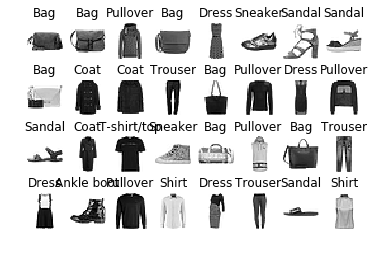

In [0]:
# Random sample a subset of data to reduce training time
# Original size = 60,000
n = 60000

# Random sample training data
idx = np.random.choice(np.arange(len(images_train)), 
                       n, replace=False)
images_train_sub = images_train[idx]
y_train = y_train_arr[idx]

# Random sample testing data
idx = np.random.choice(np.arange(len(images_test)), 
                       math.floor(n/6), replace=False)
images_test_sub = images_test[idx]
y_test = y_test_arr[idx]

# Flattern images from 28x28 matrix to vector of length 784
x_train = images_train_sub.reshape((len(images_train_sub), -1))
x_test = images_test_sub.reshape((len(images_test_sub), -1))

# Take a look at some sample images
plot_images(images_train_sub, y_train, None)

### Logistic Regression

Library for Large Linear Classification solver

-----------------------------------------------------------------
Logistic Regression using Library for Large Linear Classification solver
Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.0025, 'multi_class': 'ovr', 'max_iter': 1000}


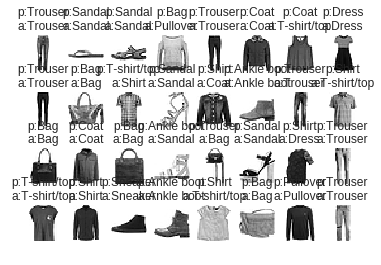

             precision    recall  f1-score   support

          0       0.81      0.82      0.81      1000
          1       0.97      0.95      0.96      1000
          2       0.73      0.73      0.73      1000
          3       0.82      0.87      0.85      1000
          4       0.71      0.78      0.74      1000
          5       0.95      0.89      0.92      1000
          6       0.67      0.53      0.59      1000
          7       0.90      0.94      0.92      1000
          8       0.91      0.96      0.93      1000
          9       0.93      0.95      0.94      1000

avg / total       0.84      0.84      0.84     10000

Training time: 420.534608725s
Testing time: 0.06168903200000386s
Total time: 420.596297757s
F1-score: 0.8389035828664266
beta=0.5
0.81, 0.97, 0.73, 0.83, 0.72, 0.94, 0.64, 0.91, 0.92, 0.93
avg: 0.838763570479004
beta=2
0.82, 0.96, 0.73, 0.86, 0.76, 0.9, 0.55, 0.93, 0.95, 0.94
avg: 0.8399485494916934


In [0]:
### SETUP
# Lists to store classification results
lgr_results_lists = ([], [], [], [])

# Title of experiments
exp_titles = (
    ('Logistic Regression using Library for Large Linear '
     'Classification solver'), 
)

# Adjust this to change the amount of messages returned by GridSearchCV
# Only accepts integers, 0 for no messages
verbose = 0

# K in K-folds cross validation during GridSearchCV
# Set to 0 after you have optimized hyperparameters to get runtime of algorithm
# Reduce to speed up Gridsearch, increase to reduce CV bias
k = 0

### EXPERIMENTS 
# Optimized Classifier on Original Data
param_grid = {'solver': ['liblinear'], 
              'penalty': ['l1'],  
              'C': [2.5e-3], 
              'multi_class': ['ovr'], 
              'max_iter': [1000]}

experiment_on_classifier(cfr = LogisticRegression, 
                         param_grid = param_grid, 
                         results_lists = lgr_results_lists)

### Summarize results
lgr_y_preds, lgr_train_times, lgr_test_times, lgr_params = lgr_results_lists
lgr_scores = summarize_results_ml(images_test_sub, y_test, lgr_y_preds, 
                                  lgr_train_times, lgr_test_times, lgr_params)

Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm solver

-----------------------------------------------------------------
Logistic Regression using Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm solver
Parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 2.5e-06, 'multi_class': 'multinomial', 'max_iter': 1000}


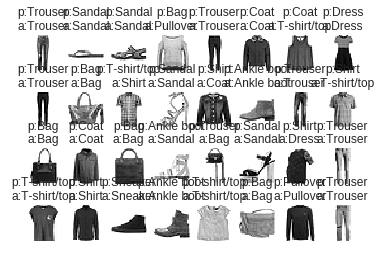

             precision    recall  f1-score   support

          0       0.81      0.80      0.81      1000
          1       0.97      0.96      0.96      1000
          2       0.73      0.74      0.74      1000
          3       0.83      0.86      0.85      1000
          4       0.72      0.78      0.75      1000
          5       0.95      0.90      0.93      1000
          6       0.65      0.57      0.60      1000
          7       0.91      0.94      0.92      1000
          8       0.93      0.95      0.94      1000
          9       0.93      0.95      0.94      1000

avg / total       0.84      0.84      0.84     10000

Training time: 476.85821663600007s
Testing time: 0.051271305999989636s
Total time: 476.90948794200006s
F1-score: 0.8432091546235482
beta=0.5
0.81, 0.97, 0.74, 0.84, 0.73, 0.94, 0.63, 0.91, 0.94, 0.93
avg: 0.8430409244028875
beta=2
0.8, 0.96, 0.74, 0.85, 0.77, 0.91, 0.58, 0.93, 0.94, 0.95
avg: 0.8437455490694671


In [0]:
### SETUP
# Lists to store classification results
lgr_results_lists = ([], [], [], [])

# Title of experiments
exp_titles = (
    ('Logistic Regression using Limited-memory Broyden–Fletcher–'
     'Goldfarb–Shanno Algorithm solver'), 
)

# Adjust this to change the amount of messages returned by GridSearchCV
# Only accepts integers, 0 for no messages
verbose = 0

# K in K-folds cross validation during GridSearchCV
# Set to 0 after you have optimized hyperparameters to get runtime of algorithm
# Reduce to speed up Gridsearch, increase to reduce CV bias
k = 0

### EXPERIMENTS 
# Optimized Classifier on Original Data
param_grid = {'solver': ['lbfgs'], 
              'penalty': ['l2'],  
              'C': [2.5e-6], 
              'multi_class': ['multinomial'], 
              'max_iter': [1000]}

experiment_on_classifier(cfr = LogisticRegression, 
                         param_grid = param_grid, 
                         results_lists = lgr_results_lists)

### Summarize results
lgr_y_preds, lgr_train_times, lgr_test_times, lgr_params = lgr_results_lists
lgr_scores = summarize_results_ml(images_test_sub, y_test, lgr_y_preds, 
                                  lgr_train_times, lgr_test_times, lgr_params)

Stochastic Average Gradient solver

-----------------------------------------------------------------
Logistic Regression using Stochastic Average Gradient solver
Parameters: {'solver': 'sag', 'penalty': 'l2', 'C': 2.5e-06, 'multi_class': 'multinomial', 'max_iter': 1000}


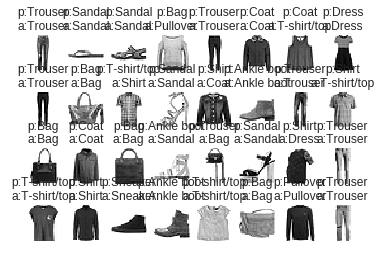

             precision    recall  f1-score   support

          0       0.81      0.80      0.81      1000
          1       0.97      0.96      0.96      1000
          2       0.73      0.74      0.74      1000
          3       0.84      0.86      0.85      1000
          4       0.72      0.78      0.75      1000
          5       0.95      0.90      0.92      1000
          6       0.65      0.57      0.60      1000
          7       0.91      0.94      0.92      1000
          8       0.93      0.95      0.94      1000
          9       0.93      0.95      0.94      1000

avg / total       0.84      0.84      0.84     10000

Training time: 214.650228749s
Testing time: 0.048449226000002454s
Total time: 214.698677975s
F1-score: 0.8432793192094519
beta=0.5
0.81, 0.97, 0.74, 0.84, 0.73, 0.94, 0.63, 0.91, 0.93, 0.93
avg: 0.8431305244480642
beta=2
0.8, 0.96, 0.74, 0.86, 0.77, 0.91, 0.58, 0.93, 0.94, 0.95
avg: 0.8438248005682091


In [0]:
### SETUP
# Lists to store classification results
lgr_results_lists = ([], [], [], [])

# Title of experiments
exp_titles = (
    'Logistic Regression using Stochastic Average Gradient solver', 
)

# Adjust this to change the amount of messages returned by GridSearchCV
# Only accepts integers, 0 for no messages
verbose = 0

# K in K-folds cross validation during GridSearchCV
# Set to 0 after you have optimized hyperparameters to get runtime of algorithm
# Reduce to speed up Gridsearch, increase to reduce CV bias
k = 0

### EXPERIMENTS 
# Optimized Classifier on Original Data
param_grid = {'solver': ['sag'], 
              'penalty': ['l2'],  
              'C': [2.5e-6], 
              'multi_class': ['multinomial'], 
              'max_iter': [1000]}

experiment_on_classifier(cfr = LogisticRegression, 
                         param_grid = param_grid, 
                         results_lists = lgr_results_lists)

### Summarize results
lgr_y_preds, lgr_train_times, lgr_test_times, lgr_params = lgr_results_lists
lgr_scores = summarize_results_ml(images_test_sub, y_test, lgr_y_preds, 
                                  lgr_train_times, lgr_test_times, lgr_params)

SAGA solver

-----------------------------------------------------------------
Logistic Regression using SAGA solver
Parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 2.5e-06, 'multi_class': 'multinomial', 'max_iter': 1000}


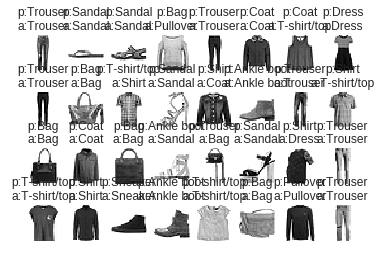

             precision    recall  f1-score   support

          0       0.81      0.80      0.81      1000
          1       0.97      0.96      0.96      1000
          2       0.73      0.74      0.74      1000
          3       0.84      0.86      0.85      1000
          4       0.72      0.78      0.75      1000
          5       0.95      0.90      0.92      1000
          6       0.65      0.57      0.60      1000
          7       0.91      0.94      0.92      1000
          8       0.93      0.95      0.94      1000
          9       0.93      0.95      0.94      1000

avg / total       0.84      0.84      0.84     10000

Training time: 558.2275629330002s
Testing time: 0.051961019999907876s
Total time: 558.2795239530001s
F1-score: 0.843288815144254
beta=0.5
0.81, 0.97, 0.74, 0.84, 0.73, 0.94, 0.63, 0.91, 0.93, 0.93
avg: 0.8431399591640687
beta=2
0.8, 0.96, 0.74, 0.86, 0.77, 0.91, 0.58, 0.93, 0.94, 0.95
avg: 0.8438299181791684


In [0]:
### SETUP
# Lists to store classification results
lgr_results_lists = ([], [], [], [])

# Title of experiments
exp_titles = ( 
    'Logistic Regression using SAGA solver', 
)

# Adjust this to change the amount of messages returned by GridSearchCV
# Only accepts integers, 0 for no messages
verbose = 0

# K in K-folds cross validation during GridSearchCV
# Set to 0 after you have optimized hyperparameters to get runtime of algorithm
# Reduce to speed up Gridsearch, increase to reduce CV bias
k = 0

### EXPERIMENTS 
# Optimized Classifier on Original Data
param_grid = {'solver': ['saga'], 
              'penalty': ['l2'],  
              'C': [2.5e-6], 
              'multi_class': ['multinomial'], 
              'max_iter': [1000]}

experiment_on_classifier(cfr = LogisticRegression, 
                         param_grid = param_grid, 
                         results_lists = lgr_results_lists)

### Summarize results
lgr_y_preds, lgr_train_times, lgr_test_times, lgr_params = lgr_results_lists
lgr_scores = summarize_results_ml(images_test_sub, y_test, lgr_y_preds, 
                                  lgr_train_times, lgr_test_times, lgr_params)

Newton's Method solver

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


-----------------------------------------------------------------
Logistic Regression using Newton's Method solver
Parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 2.5e-06, 'multi_class': 'multinomial', 'max_iter': 1000}


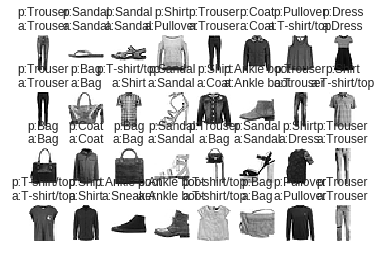

             precision    recall  f1-score   support

          0       0.80      0.81      0.81      1000
          1       0.98      0.95      0.97      1000
          2       0.73      0.74      0.73      1000
          3       0.83      0.87      0.85      1000
          4       0.74      0.77      0.75      1000
          5       0.94      0.92      0.93      1000
          6       0.63      0.57      0.60      1000
          7       0.91      0.94      0.92      1000
          8       0.93      0.94      0.94      1000
          9       0.95      0.94      0.95      1000

avg / total       0.85      0.85      0.85     10000

Training time: 13831.584997345999s
Testing time: 0.052275255000495235s
Total time: 13831.637272601s
F1-score: 0.8453779226378384
beta=0.5
0.8, 0.97, 0.73, 0.84, 0.75, 0.94, 0.62, 0.91, 0.93, 0.95
avg: 0.8451474424836893
beta=2
0.81, 0.96, 0.73, 0.86, 0.76, 0.93, 0.59, 0.94, 0.94, 0.94
avg: 0.8458067587552603


In [0]:
### SETUP
# Lists to store classification results
lgr_results_lists = ([], [], [], [])

# Title of experiments
exp_titles = (
    'Logistic Regression using Newton\'s Method solver',
)

# Adjust this to change the amount of messages returned by GridSearchCV
# Only accepts integers, 0 for no messages
verbose = 0

# K in K-folds cross validation during GridSearchCV
# Set to 0 after you have optimized hyperparameters to get runtime of algorithm
# Reduce to speed up Gridsearch, increase to reduce CV bias
k = 0

### EXPERIMENTS 
# Optimized Classifier on Original Data
param_grid = {'solver': ['newton-cg'], 
              'penalty': ['l2'], 
              'C': [2.5e-6], 
              'multi_class': ['multinomial'], 
              'max_iter': [1000]}

experiment_on_classifier(cfr = LogisticRegression, 
                         param_grid = param_grid, 
                         results_lists = lgr_results_lists)
### Summarize results
lgr_y_preds, lgr_train_times, lgr_test_times, lgr_params = lgr_results_lists
lgr_scores = summarize_results_ml(images_test_sub, y_test, lgr_y_preds, 
                                  lgr_train_times, lgr_test_times, lgr_params)

### k-Nearest Neighbors

Ball tree data structure

-----------------------------------------------------------------
K-Nearest Neighbors using ball tree
Parameters: {'n_neighbors': 5, 'algorithm': 'ball_tree'}


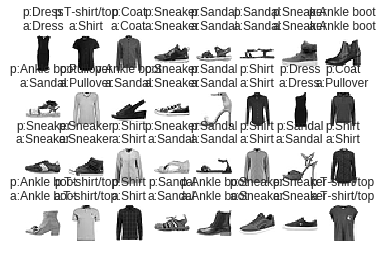

             precision    recall  f1-score   support

          0       0.77      0.85      0.81      1000
          1       0.99      0.97      0.98      1000
          2       0.73      0.82      0.77      1000
          3       0.90      0.86      0.88      1000
          4       0.79      0.77      0.78      1000
          5       0.99      0.82      0.90      1000
          6       0.66      0.57      0.61      1000
          7       0.88      0.96      0.92      1000
          8       0.97      0.95      0.96      1000
          9       0.90      0.97      0.93      1000

avg / total       0.86      0.86      0.85     10000

Training time: 20.481508426999994s
Testing time: 1045.668571656s
Total time: 1066.150080083s
F1-score: 0.8546439722018905
beta=0.5
0.79, 0.98, 0.75, 0.89, 0.78, 0.95, 0.64, 0.89, 0.97, 0.91
avg: 0.856051447208735
beta=2
0.84, 0.97, 0.8, 0.87, 0.78, 0.85, 0.59, 0.94, 0.96, 0.95
avg: 0.854645503786576


In [0]:
### SETUP
# Lists to store classification results
knn_results_lists = ([], [], [], [])

# Title of experiments
exp_titles = (
    'K-Nearest Neighbors using ball tree',
)

# Adjust this to change the amount of messages returned by GridSearchCV
# Only accepts integers, 0 for no messages
verbose = 0

# K in K-folds cross validation during GridSearchCV
# Set to 0 after you have optimized hyperparameters to get runtime of algorithm
# Reduce to speed up Gridsearch, increase to reduce CV bias
k = 0

### EXPERIMENTS 
# # Optimized Classifier on Original Data
param_grid = {'n_neighbors': [5], 
              'algorithm': ['ball_tree']}

experiment_on_classifier(cfr = KNeighborsClassifier, 
                          param_grid = param_grid, 
                          results_lists = knn_results_lists)

### Summarize results
knn_y_preds, knn_train_times, knn_test_times, knn_params = knn_results_lists
knn_scores = summarize_results_ml(images_test_sub, y_test, knn_y_preds, 
                                  knn_train_times, knn_test_times, knn_params)

k-d tree data structure

-----------------------------------------------------------------
K-Nearest Neighbors using k-d tree
Parameters: {'n_neighbors': 5, 'algorithm': 'kd_tree'}


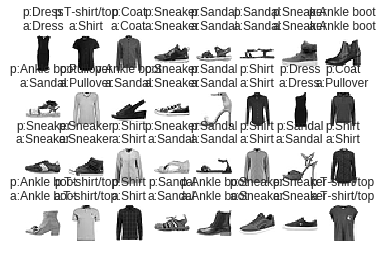

             precision    recall  f1-score   support

          0       0.77      0.85      0.81      1000
          1       0.99      0.97      0.98      1000
          2       0.73      0.82      0.77      1000
          3       0.90      0.86      0.88      1000
          4       0.79      0.77      0.78      1000
          5       0.99      0.82      0.90      1000
          6       0.66      0.57      0.61      1000
          7       0.88      0.96      0.92      1000
          8       0.97      0.95      0.96      1000
          9       0.90      0.97      0.93      1000

avg / total       0.86      0.86      0.85     10000

Training time: 19.530873027000098s
Testing time: 1110.7266323130002s
Total time: 1130.2575053400003s
F1-score: 0.8546439722018905
beta=0.5
0.79, 0.98, 0.75, 0.89, 0.78, 0.95, 0.64, 0.89, 0.97, 0.91
avg: 0.856051447208735
beta=2
0.84, 0.97, 0.8, 0.87, 0.78, 0.85, 0.59, 0.94, 0.96, 0.95
avg: 0.854645503786576


In [0]:
### SETUP
# Lists to store classification results
knn_results_lists = ([], [], [], [])

# Title of experiments
exp_titles = (
    'K-Nearest Neighbors using k-d tree',
)

# Adjust this to change the amount of messages returned by GridSearchCV
# Only accepts integers, 0 for no messages
verbose = 0

# K in K-folds cross validation during GridSearchCV
# Set to 0 after you have optimized hyperparameters to get runtime of algorithm
# Reduce to speed up Gridsearch, increase to reduce CV bias
k = 0

### EXPERIMENTS 
# # Optimized Classifier on Original Data
param_grid = {'n_neighbors': [5], 
              'algorithm': ['kd_tree']}

experiment_on_classifier(cfr = KNeighborsClassifier, 
                          param_grid = param_grid, 
                          results_lists = knn_results_lists)

### Summarize results
knn_y_preds, knn_train_times, knn_test_times, knn_params = knn_results_lists
knn_scores = summarize_results_ml(images_test_sub, y_test, knn_y_preds, 
                                  knn_train_times, knn_test_times, knn_params)

### Support Vector Machine

Sigmoid kernel

In [0]:
### SETUP
# Lists to store classification results
svc_results_lists = ([], [], [], [])

# Title of experiments
exp_titles = (
    'Support Vector Classifier using Sigmoid kernel',
)

# Adjust this to change the amount of messages returned by GridSearchCV
# Only accepts integers, 0 for no messages
verbose = 0

# K in K-folds cross validation during GridSearchCV
# Set to 0 after you have optimized hyperparameters to get runtime of algorithm
# Reduce to speed up Gridsearch, increase to reduce CV bias
k = 0

### EXPERIMENTS 
#Optimized Classifier on Original Data
param_grid = {'kernel': ['sigmoid'], 
              'C': [1e-1], 
              'gamma': [1e-1], 
              'coef0': [1e-1]}

experiment_on_classifier(cfr = SVC, 
                         param_grid = param_grid, 
                         results_lists = svc_results_lists)

### Summarize results
svc_y_preds, svc_train_times, svc_test_times, svc_params = svc_results_lists
svc_scores = summarize_results_ml(images_test_sub, y_test, svc_y_preds, 
                                  svc_train_times, svc_test_times, svc_params)

Linear kernel

-----------------------------------------------------------------
Support Vector Machine using Linear kernel
Parameters: {'dual': True, 'multi_class': 'crammer_singer', 'C': 5e-07}


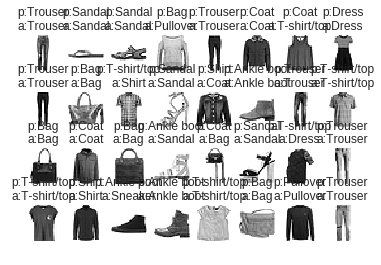

             precision    recall  f1-score   support

          0       0.80      0.83      0.81      1000
          1       0.96      0.96      0.96      1000
          2       0.74      0.74      0.74      1000
          3       0.83      0.86      0.85      1000
          4       0.70      0.79      0.74      1000
          5       0.96      0.90      0.93      1000
          6       0.68      0.54      0.60      1000
          7       0.90      0.94      0.92      1000
          8       0.93      0.95      0.94      1000
          9       0.93      0.95      0.94      1000

avg / total       0.84      0.85      0.84     10000

Training time: 148.67110535400207s
Testing time: 0.08814319399971282s
Total time: 148.75924854800178s
F1-score: 0.843416343950395
beta=0.5
0.81, 0.96, 0.74, 0.84, 0.72, 0.95, 0.64, 0.91, 0.93, 0.93
avg: 0.8433645190013609
beta=2
0.82, 0.96, 0.74, 0.85, 0.77, 0.91, 0.56, 0.94, 0.95, 0.94
avg: 0.8443882523602262


In [0]:
### SETUP
# Lists to store classification results
lsv_results_lists = ([], [], [], [])

# Title of experiments
exp_titles = (
    'Support Vector Machine using Linear kernel',
)

# Adjust this to change the amount of messages returned by GridSearchCV
# Only accepts integers, 0 for no messages
verbose = 0

# K in K-folds cross validation during GridSearchCV
# Set to 0 after you have optimized hyperparameters to get runtime of algorithm
# Reduce to speed up Gridsearch, increase to reduce CV bias
k = 0

### EXPERIMENTS 
# Optimized Classifier
param_grid = {'dual': [True], 
              'multi_class': ['crammer_singer'],
              'C': [5e-7]}

experiment_on_classifier(cfr = LinearSVC, 
                         param_grid = param_grid, 
                         results_lists = lsv_results_lists)
### Summarize results
lsv_y_preds, lsv_train_times, lsv_test_times, lsv_params = lsv_results_lists
lsv_scores = summarize_results_ml(images_test_sub, y_test, lsv_y_preds, 
                                  lsv_train_times, lsv_test_times, lsv_params)

Radial-basis function

-----------------------------------------------------------------
Support Vector Classifier using Radial-basis function kernel
Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 2.5e-07}


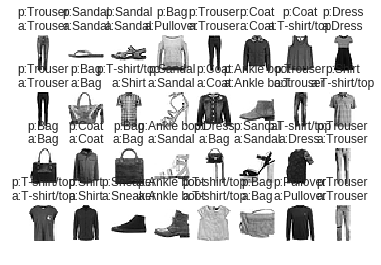

             precision    recall  f1-score   support

          0       0.84      0.85      0.85      1000
          1       0.99      0.98      0.98      1000
          2       0.82      0.84      0.83      1000
          3       0.91      0.91      0.91      1000
          4       0.84      0.84      0.84      1000
          5       0.98      0.98      0.98      1000
          6       0.75      0.73      0.74      1000
          7       0.96      0.97      0.96      1000
          8       0.98      0.98      0.98      1000
          9       0.97      0.97      0.97      1000

avg / total       0.90      0.90      0.90     10000

Training time: 968.2754729139997s
Testing time: 336.86859902500146s
Total time: 1305.1440719390012s
F1-score: 0.9038452714417898
beta=0.5
0.85, 0.99, 0.83, 0.91, 0.84, 0.98, 0.75, 0.96, 0.98, 0.97
avg: 0.9037972323445675
beta=2
0.85, 0.98, 0.84, 0.91, 0.84, 0.98, 0.73, 0.96, 0.98, 0.97
avg: 0.9039270079705602


In [0]:
### SETUP
# Lists to store classification results
svc_results_lists = ([], [], [], [])

# Title of experiments
exp_titles = (
    'Support Vector Classifier using Radial-basis function kernel',
)

# Adjust this to change the amount of messages returned by GridSearchCV
# Only accepts integers, 0 for no messages
verbose = 0

# K in K-folds cross validation during GridSearchCV
# Set to 0 after you have optimized hyperparameters to get runtime of algorithm
# Reduce to speed up Gridsearch, increase to reduce CV bias
k = 0

### EXPERIMENTS 
#Optimized Classifier on Original Data
param_grid = {'kernel': ['rbf'], 
              'C': [1e1], 
              'gamma': [2.5e-7]}

experiment_on_classifier(cfr = SVC, 
                         param_grid = param_grid, 
                         results_lists = svc_results_lists)

### Summarize results
svc_y_preds, svc_train_times, svc_test_times, svc_params = svc_results_lists
svc_scores = summarize_results_ml(images_test_sub, y_test, svc_y_preds, 
                                  svc_train_times, svc_test_times, svc_params)

# Deep Learning Algorithms

### Pre-processing

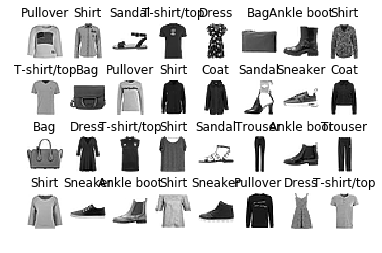

In [0]:
# Random sample a subset of data to reduce training time
# Original size = 60,000
n = 60000

# Random sample training data
idx = np.random.choice(np.arange(len(images_train)), 
                       n, replace=False)
images_sub_train = images_train[idx]
y_sub_train_arr = y_train_arr[idx]
x_train = images_sub_train.reshape(images_sub_train.shape[0], 
                                   28, 28 , 1).astype('float32')

# One-hot encoding
y_train = np_utils.to_categorical(y_sub_train_arr)

# Random sample testing data
idx = np.random.choice(np.arange(len(images_test)), 
                       math.floor(n/6), replace=False)
images_sub_test = images_test[idx]
y_sub_test_arr = y_test_arr[idx]
x_test = images_sub_test.reshape(images_sub_test.shape[0], 
                                 28, 28 , 1).astype('float32')

# One-hot encoding
y_test = np_utils.to_categorical(y_sub_test_arr)

# Take a look at some sample images
plot_images(images_sub_train, y_sub_train_arr, None)

### Multilayer Perceptron

Additional pre-processing

In [0]:
# Flattern images from 28x28 matrix to vector of length 784
x_train_mlp = images_sub_train.reshape((len(images_sub_train), 
                                        -1)).astype('float32')

# Scale vector from [0,255] to [0,1]
x_train_mlp = x_train_mlp/255

# Flattern images from 28x28 matrix to vector of length 784
x_test_mlp = images_sub_test.reshape((len(images_sub_test), 
                                      -1)).astype('float32')

# Scale vector from [0,255] to [0,1]
x_test_mlp = x_test_mlp/255

Train using original images

Train on 48000 samples, validate on 12000 samples
Epoch 1/256
48000/48000 [==============================] - 4s 82us/step - loss: 1.0135 - acc: 0.6095 - val_loss: 0.5485 - val_acc: 0.7931
Epoch 2/256
48000/48000 [==============================] - 4s 77us/step - loss: 0.5945 - acc: 0.7898 - val_loss: 0.4757 - val_acc: 0.8299
Epoch 3/256
48000/48000 [==============================] - 4s 76us/step - loss: 0.5378 - acc: 0.8141 - val_loss: 0.4594 - val_acc: 0.8397
Epoch 4/256
48000/48000 [==============================] - 4s 77us/step - loss: 0.5053 - acc: 0.8256 - val_loss: 0.4412 - val_acc: 0.8457
Epoch 5/256
48000/48000 [==============================] - 4s 77us/step - loss: 0.4903 - acc: 0.8312 - val_loss: 0.4418 - val_acc: 0.8508
Epoch 6/256
48000/48000 [==============================] - 4s 78us/step - loss: 0.4793 - acc: 0.8364 - val_loss: 0.4305 - val_acc: 0.8550
Epoch 7/256
48000/48000 [==============================] - 4s 77us/step - loss: 0.4639 - acc: 0.8404 - val_loss: 0.4152 - 

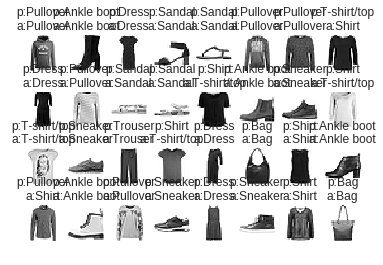

Predicted    0    1     2    3    4    5     6     7    8    9    All
True                                                                 
0          834    0    10   16    1    0   132     0    7    0   1000
1            5  969     2   18    3    0     1     0    2    0   1000
2           15    1   845   12   62    0    65     0    0    0   1000
3           28    6    13  888   23    0    36     0    6    0   1000
4            1    1   128   32  790    0    45     0    3    0   1000
5            0    0     0    1    0  951     0    27    2   19   1000
6          100    2    97   21   61    0   709     0   10    0   1000
7            0    0     0    0    0   18     0   961    0   21   1000
8            3    2     4    5    3    2    13     4  964    0   1000
9            0    0     0    0    0    7     1    36    0  956   1000
All        986  981  1099  993  943  978  1002  1028  994  996  10000
             precision    recall  f1-score   support

          0       0.85      0.83    

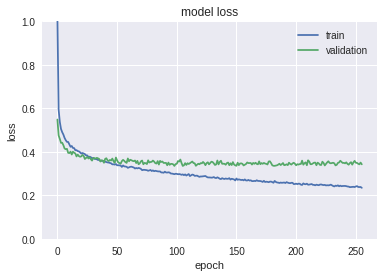

beta=0.5
0.84, 0.98, 0.78, 0.89, 0.83, 0.97, 0.71, 0.94, 0.97, 0.96
avg: 0.8874704754855263
beta=2
0.84, 0.97, 0.83, 0.89, 0.8, 0.96, 0.71, 0.96, 0.97, 0.96
avg: 0.8867478017232606
{'loss': 0.3673322068572044, 'accuracy': 0.8867, 'f1': 0.8870030018735306, 'fb_05': 0.8874704754855263, 'fb_2': 0.8867478017232606}


In [0]:
run_type = 'Multilayer Perceptron'
epochs = 256
batch_size = 128

# Define model
model = Sequential()
model.add(Dense(256, activation='tanh', kernel_initializer='he_normal', 
                input_shape=(784,)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='tanh', kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(100, activation='tanh', kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='sigmoid', kernel_initializer='he_normal'))

# Initialize model
optim = SGD(lr=0.01, momentum=0.975, decay=2e-06, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

# Train model
history = model.fit(x_train_mlp, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

# Evaluate model
scores = model.evaluate(x_test_mlp, y_test)
scores = {'loss': scores[0], 
          'accuracy': scores[1]}
y_pred = model.predict(x_test_mlp)
mlp_score = summarize_results_dl(images_sub_test, scores, history, 
                                 y_test.argmax(axis=1), y_pred.argmax(axis=1), 
                                 run_type)

Image augmentation

In [0]:
x_train_mlp = x_train
y_train_mlp = y_train

# Define augmentated image generator
datagen = ImageDataGenerator(
    rotation_range=2,
    width_shift_range=0.02,
    height_shift_range=0.02)

# Train image generator
datagen.fit(x_train_mlp)

# Append augmented images to original
for x_batch, y_batch in datagen.flow(x_train_mlp, y_train_mlp, batch_size=n): 
  x_train_mlp = np.append(x_train_mlp, x_batch, axis=0)
  y_train_mlp = np.append(y_train_mlp, y_batch, axis=0)
  break;

# Flattern images from 28x28 matrix to vector of length 784
x_train_mlp = x_train_mlp.reshape((len(x_train_mlp), -1))

# Scale vector from [0,255] to [0,1]
x_train_mlp = x_train_mlp/255

Train using augmented images and original images combined

In [0]:
run_type = 'Multilayer Perceptron with Image Augmentation'
epochs = 512
batch_size = 128

# Define model
model = Sequential()

model.add(Dense(256, activation='tanh', kernel_initializer='he_normal', 
                input_shape=(784,)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='tanh', kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(100, activation='tanh', kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='sigmoid', kernel_initializer='he_normal'))

# Initialize model
optim = SGD(lr=0.01, momentum=0.975, decay=2e-06, nesterov=True)
model.compile(loss='categorical_crossentropy',
			  optimizer=optim,
			  metrics=['accuracy'])

# Train model
history = model.fit(x_train_mlp, y_train_mlp,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

# Evaluate model
scores = model.evaluate(x_test_mlp, y_test)
scores = {'loss': scores[0], 
          'accuracy': scores[1]}
y_pred = model.predict(x_test_mlp)
dnn_aug_scores = summarize_results_dl(images_sub_test, scores, history, 
                                      y_test.argmax(axis=1), 
                                      y_pred.argmax(axis=1), run_type)

Train on 96000 samples, validate on 24000 samples
Epoch 1/512
96000/96000 [==============================] - 8s 80us/step - loss: 0.7978 - acc: 0.7085 - val_loss: 0.4829 - val_acc: 0.8267
Epoch 2/512
96000/96000 [==============================] - 7s 73us/step - loss: 0.5390 - acc: 0.8119 - val_loss: 0.4704 - val_acc: 0.8340
Epoch 3/512
96000/96000 [==============================] - 7s 74us/step - loss: 0.5023 - acc: 0.8253 - val_loss: 0.4357 - val_acc: 0.8476
Epoch 4/512
96000/96000 [==============================] - 7s 74us/step - loss: 0.4788 - acc: 0.8339 - val_loss: 0.4133 - val_acc: 0.8546
Epoch 5/512
96000/96000 [==============================] - 7s 73us/step - loss: 0.4624 - acc: 0.8384 - val_loss: 0.4197 - val_acc: 0.8521
Epoch 6/512
96000/96000 [==============================] - 7s 73us/step - loss: 0.4515 - acc: 0.8416 - val_loss: 0.3993 - val_acc: 0.8610
Epoch 7/512
96000/96000 [==============================] - 7s 72us/step - loss: 0.4425 - acc: 0.8451 - val_loss: 0.3855 - 

### Convolutional Neural Network

LeNet-5

In [0]:
run_type = "Convolution Neural Network (LeNet-5)"
epochs = 128
batch_size = 128

# Define model
model = Sequential()

# Convolution layer
model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', 
                 kernel_initializer='lecun_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='tanh', 
                 kernel_initializer='lecun_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())

# Dense layer
model.add(Dense(units=128, activation='tanh', 
                kernel_initializer='lecun_uniform'))
model.add(Dense(units=84, activation='tanh', 
                kernel_initializer='lecun_uniform'))
model.add(Dense(units=10, activation='softmax', 
                kernel_initializer='lecun_uniform'))

# Initialize model
model.compile(loss='categorical_crossentropy', optimizer='sgd', 
              metrics=['accuracy'])

# Train model
history = model.fit(x_train, y_train, 
                    epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate model
scores = model.evaluate(x_test, y_test, verbose=10)
scores = {'loss': scores[0], 
          'accuracy': scores[1]}
y_pred = model.predict(x_test)
len_scores = summarize_results_dl(images_sub_test, scores, history, 
                                  y_test.argmax(axis=1), y_pred.argmax(axis=1), 
                                  run_type)

Train on 48000 samples, validate on 12000 samples
Epoch 1/128
  896/48000 [..............................] - ETA: 1:01 - loss: 2.2883 - acc: 0.1551

KeyboardInterrupt: ignored

JoNet-0

Train on 48000 samples, validate on 12000 samples
Epoch 1/1
10000/10000 [==============================] - 34s 3ms/step
-----------------------------------------------------------------
Convolution Neural Network (JoNet-0)


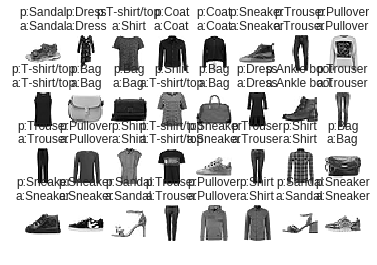

Predicted     0    1     2    3     4     5    6     7    8    9    All
True                                                                   
0           883    0    18    7     3     1   83     0    4    1   1000
1             4  979     0   10     5     0    1     0    1    0   1000
2            16    1   883    7    43     0   49     0    1    0   1000
3            14    1    10  928    21     0   25     0    1    0   1000
4             1    0    50   16   884     0   47     0    2    0   1000
5             0    0     0    0     0   989    0     7    0    4   1000
6            98    1    54   19    61     0  761     0    6    0   1000
7             0    0     0    0     0     8    0   983    0    9   1000
8             2    0     2    4     2     2    3     2  982    1   1000
9             0    0     0    0     0     6    0    35    0  959   1000
All        1018  982  1017  991  1019  1006  969  1027  997  974  10000
             precision    recall  f1-score   support

          

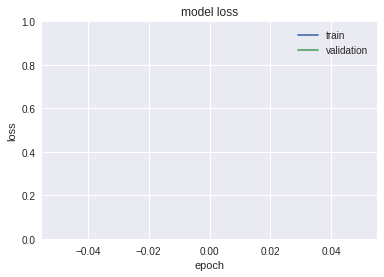

beta=0.5
0.87, 0.99, 0.87, 0.93, 0.87, 0.98, 0.78, 0.96, 0.98, 0.98
avg: 0.9230993379636644
beta=2
0.88, 0.98, 0.88, 0.93, 0.88, 0.99, 0.77, 0.98, 0.98, 0.96
avg: 0.9230589626739153
{'loss': 0.2688181119501591, 'accuracy': 0.9231, 'f1': 0.9230484337436696, 'fb_01': 0.9230993379636644, 'fb_10': 0.9230589626739153}


In [0]:
run_type = "Convolution Neural Network (JoNet-0)"
epochs = 1
batch_size = 128
weights_file = 'cnn_weights.h5'

# Horizontal symmetry of clothes
top, bottom = np.split(images_sub_train, 2, 1)
bottom = np.flip(bottom, 1)
sub = np.subtract(top.astype(np.int16), bottom.astype(np.int16))
sub = np.maximum(sub, 0)
hor_train = (sub>100).sum(axis=(1,2))

top, bottom = np.split(images_sub_test, 2, 2)
bottom = np.flip(bottom, 1)
sub = np.subtract(top.astype(np.int16), bottom.astype(np.int16))
sub = np.maximum(sub, 0)
hor_test = (sub>100).sum(axis=(1,2))

# Size of clothes
org_train = (images_sub_train>10).sum(axis=(1,2))
org_test = (images_sub_test>10).sum(axis=(1,2))

# Average intensity of clothes
avg_train = images_sub_train.mean(axis=(1,2))
avg_test = images_sub_test.mean(axis=(1,2))

# Concatenating all of the features
final_train = np.column_stack((org_train, avg_train, hor_train))
final_test = np.column_stack((org_test, avg_test, hor_test))

# Engineered feature layer
extra_in = Input(shape=(3,))
extra_dense = Dense(units=128, activation='relu', 
                    kernel_regularizer=l2(0.01))(extra_in)

# Convolution layer large
conv_large_in = Input(shape=(28, 28, 1))
conv_large_conv_1 = Conv2D(filters=32, kernel_size=(5, 5), 
                           activation='relu')(conv_large_in)
conv_large_pool_1 = MaxPooling2D(pool_size=(2, 2), 
                                 strides=(2, 2))(conv_large_conv_1)
conv_large_drop_1 = Dropout(rate=0.1)(conv_large_pool_1)
conv_large_conv_2 = Conv2D(filters=64, kernel_size=(5, 5), 
                           activation='relu')(conv_large_drop_1)
conv_large_pool_2 = MaxPooling2D(pool_size=(2, 2), 
                                 strides=(2, 2))(conv_large_conv_2)
conv_large_drop_2 = Dropout(rate=0.1)(conv_large_pool_2)
conv_large_flat = Flatten()(conv_large_drop_2)

# Convolution layer small
conv_small_in = Input(shape=(28, 28, 1))
conv_small_conv_1 = Conv2D(filters=32, kernel_size=(3, 3), 
                           activation='relu')(conv_small_in)
conv_small_pool_1 = MaxPooling2D(pool_size=(2, 2), 
                                 strides=(2, 2))(conv_small_conv_1)
conv_small_drop_1 = Dropout(rate=0.1)(conv_small_pool_1)
conv_small_conv_2 = Conv2D(filters=64, kernel_size=(3, 3), 
                           activation='relu')(conv_small_drop_1)
conv_small_pool_2 = MaxPooling2D(pool_size=(2, 2), 
                                 strides=(2, 2))(conv_small_conv_2)
conv_small_drop_2 = Dropout(rate=0.1)(conv_small_pool_2)
conv_small_flat = Flatten()(conv_small_drop_2)

# Define model
concatenated = concatenate([conv_large_flat, conv_small_flat, extra_dense])
dense_1 = Dense(units=4096, activation='relu', 
                kernel_regularizer=l2(0.01))(concatenated)
main_drop_1 = Dropout(rate=0.1)(dense_1)
dense_2 = Dense(units=2048, activation='relu', 
                kernel_regularizer=l2(0.01))(main_drop_1)
main_drop_2 = Dropout(rate=0.1)(dense_2)
dense_3 = Dense(units=1024, activation='relu', 
                kernel_regularizer=l2(0.01))(main_drop_2)
main_drop_3 = Dropout(rate=0.1)(dense_3)
out = Dense(units=10, activation='softmax')(main_drop_3)

# Initialize model
main_model = Model(inputs=[conv_large_in, conv_small_in, extra_in], outputs=out)
if weights_file:
  main_model.load_weights(weights_file)
adam = Adam(lr=0.00005)
main_model.compile(loss='categorical_crossentropy', optimizer=adam, 
                   metrics=['accuracy'])

# Train model
history = main_model.fit([x_train, x_train, final_train], y_train, 
                         epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evalutate model
scores = main_model.evaluate([x_test, x_test, final_test], y_test)
scores = {'loss': scores[0], 
          'accuracy': scores[1]}
y_pred = main_model.predict([x_test, x_test, final_test])
jon_score = summarize_results_dl(images_sub_test, scores, history, 
                                 y_test.argmax(axis=1), y_pred.argmax(axis=1), 
                                 run_type)

# Save model
if weights_file:
  main_model.save_weights(weights_file)